#### A1Q5: Implementing VNS and GNS Algorithms

Schwefel Cost Function: 

$$
\begin{align}
    f(x)=418.982 d - \sum^{d}_{j=1} x_j \sin\bigg(\sqrt{|{x_j}|}\bigg)
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [117]:
neighborhood_count = 5  # number of neighborhoods
domain = [-500, 500]  # permissible x_j values
tolerance = 0.01  # final fitness is accurate to this number
d = 2  # dimensions in R^d

In [3]:
def schwefel(x):
    f = 418.982 * d
    for xi in x:
        f = f - (xi * np.sin(np.sqrt(np.abs(xi))))
    return f

**Variable Neighborhood Search (VNS)** Algorithm

First, partition the search space based on the number of neighborhoods (a hyperparameter).

Parition based on the domain of $x_j$:

$$
\begin{align}
    x_j \in [-500, 500]
\end{align}
$$

For example, 2 partitions would be 2 even cuts with sub-domains:

$$
\begin{align}
    P_1: x_j &\in [-500, 0] \\
    P_2: x_j &\in (0, 500]

\end{align}
$$

In [89]:
# Partition the search space into neighborhoods

def partition_neighborhoods(domain, neighborhood_size):
    neighborhood_size = (domain[1] - domain[0]) / neighborhood_count
    neighborhoods = np.array([[domain[0] + neighborhood_size * i, domain[0] +
                            neighborhood_size * (i+1)] for i in range(neighborhood_count)])
    return neighborhoods

partition_neighborhoods(domain, neighborhood_count)

array([[-500., -300.],
       [-300., -100.],
       [-100.,  100.],
       [ 100.,  300.],
       [ 300.,  500.]])

Algorithm:

1. Start at the minimum value of each neighborhood (ex. $[-500, ..., -500]$ for $P_1 : x_j \in [-500,-300]$)
2. Compute the fitness
3. If the fitness is greater than the previous fitness of that neighborhood, then update the local best
4. Otherwise, increment a counter to mark that neighborhood as searched
5. If the fitness is greater than the global best, then update the global best then go back to the first neighborhood and continue the search
6. Otherwise, increment $x_j$ and search the next neighborhood
7. If all neighborhoods are 'searched', then end the loop, otherwise continue

Essentially search each neighborhood until the first local maxima. 'Convergence' occurs when all neighborhoods reach this local maxima

In [115]:
def variable_neighborhood_search(neighborhood_count, domain, fitness_function):
    neighborhoods = partition_neighborhoods(domain, neighborhood_count)
    gbest_fitness = 0
    best_x = [0] * d
    count = 0
    iteration = 0
    fitness = -1000
    neighborhood_best = [0] * neighborhood_count
    x_j = [[i[0]] * d for i in neighborhoods]
    history = [ [] for _ in range(neighborhood_count) ]

    # while not converged...
    while (count < neighborhood_count):

        # for each neighborhood...
        for i in range(neighborhood_count):
            fitness = fitness_function(x_j[i])

            # check if the current x_j is a local maxima
            if fitness < neighborhood_best[i]:
                count += 1
                
            # if the function is still increasing, then increment x_j
            elif fitness > neighborhood_best[i]:
                neighborhood_best[i] = fitness
                count = 0
                history[i].append([x_j[i], fitness])
                x_j[i] = [j + np.random.randint(1,5) for j in x_j[i]]

                # ensure x_j stays within its own neighborhood
                x_j[i] = [j if neighborhoods[i][0] <= j <= neighborhoods[i][1] else neighborhoods[i][1]
                            if j > neighborhoods[i][1] else neighborhoods[i][0] for j in x_j[i]]

                iteration += 1

            # check if the current x_j is a global maxima
            if fitness > gbest_fitness:
                best_x = x_j[i]
                gbest_fitness = fitness
                i = 0

    # report statistics
    print("Best fitness: ", gbest_fitness)
    print("Best x_j: ", best_x)
    print("Iterations: ", iteration)
    print("Local best for each neighborhood: ", neighborhood_best)
    print("Best x_j for each neighborhood: ", x_j)

    return history, [x_j, neighborhood_best], [best_x, gbest_fitness]


history, local_best, global_best = variable_neighborhood_search(neighborhood_count, domain, schwefel)


Best fitness:  1673.7592868851548
Best x_j:  [-416.0, -424.0]
Iterations:  96
Local best for each neighborhood:  [1673.7592868851548, 1239.3301781777448, 964.9142822807902, 1083.2822381188487, 1438.4831599941256]
Best x_j for each neighborhood:  [[-416.0, -424.0], [-207.0, -199.0], [-62.0, -64.0], [129.0, 127.0], [304.0, 305.0]]


**Plot for VNS**

* Note: This plot is only for 3D data (ie. $d=3$)

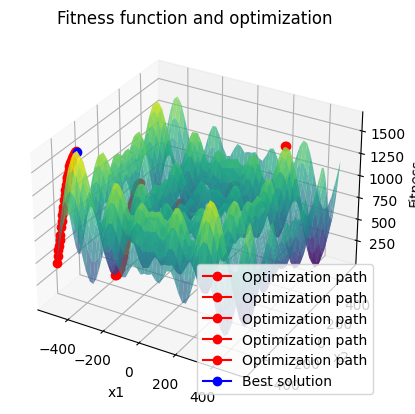

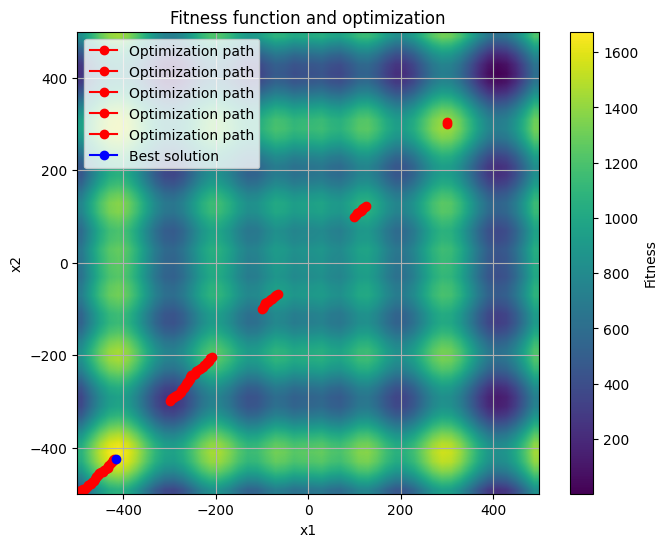

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X1, X2 = np.meshgrid(np.linspace(-500, 500, 50), np.linspace(-500, 500, 50))

# Initialize an empty array to store the cost values
Z = np.zeros_like(X1)

# Calculate the cost for each combination of X1 and X2
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        Z[i][j] = schwefel([X1[i][j], X2[i][j]])

# Plot the surface
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.7)

for i in range(neighborhood_count):
    ax.plot([i[0][0] for i in history[i]], [i[0][1] for i in history[i]], [i[1] for i in history[i]], marker='o', linestyle='-', color='red', label='Optimization path')

ax.plot(global_best[0][0], global_best[0][1], global_best[1], marker='o', linestyle='-', color='blue', label='Best solution')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Fitness')
ax.set_title('Fitness function and optimization')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(-500, 500, -500, 500), origin='lower', cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Fitness')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fitness function and optimization')
plt.grid(True)

# Overlay the optimization path on the heatmap as red dots
for i in range(neighborhood_count):
    plt.plot([i[0][0] for i in history[i]], [i[0][1] for i in history[i]], c='red', marker='o', linestyle='-', label='Optimization path')

plt.plot(global_best[0][0], global_best[0][1], c='blue', marker='o', linestyle='-', label='Best solution')
plt.legend()
plt.show()

**Generalized Neighborhood Search (GNS)** Algorithm

My strategy for this algorithm is to run the VNS in several regions in parallel. The regions overlap each other and are positioned about an optimal solution found by local search. For simplicity, I will chose the center to be the center of the domain, $x_j=[0, 0]$

For example, in the domain $x_j \in [-500, 500]$ and following a 5-region layout, the regions would be:

$$
\begin{align}
    R_1 &: x_j \in [-100, 100] \\
    R_2 &: x_j \in [-200, 200] \\
    R_3 &: x_j \in [-300, 300] \\
    R_4 &: x_j \in [-400, 400] \\
    R_5 &: x_j \in [-500, 500] 
\end{align}
$$

Neighborhood selection would then follow the below set-up where each neighborhood extends out in a certain direction. Updating $x_j$ for each neighborhood would be adjusting $x_j$ by a factor of the vector in the neighborhood's direction. For example, if there are 4 neighborhoods in $R^2$ space, then the basis vectors could be:

$$
\begin{align}
    V_1 &: [1,0] \quad \text{positive } x_1 \text{ direction} \\
    V_2 &: [0,1] \quad \text{positive } x_2 \text{ direction} \\
    V_3 &: [-1,0] \quad \text{negative } x_1 \text{ direction} \\
    V_4 &: [0,-1] \quad \text{negative } x_2 \text{ direction}
\end{align}
$$

An example update in $N_1$ from the initial $x_j^{(0)}=[0,0]$ point with $\alpha=0.5$:

$$
\begin{align}
    x_j^{(1)} = x_j^{(0)} + \alpha [1, 0] = [0.5, 0]
\end{align}
$$

To initialize the search, start from the largest regions and work toward the smaller regions. If the search converges to a local optima in that region, then wait for the VNS in that region to end before jumping to the next region and continuing the search until all regions have been searched

For this question, assume there are 8 neighborhoods and 5 regions in $R^2$ space (these can be hyperparameters). These numbers are chosen for easier calculation of the basis vectors and region spaces

In [123]:
# Hyperparameters (I hardcoded the algorithm so changing these will do nothing)
num_neighborhoods = 8
num_regions = 5
d = 2
alpha = [1] * d # x_j update factor

In [126]:
# Initial calculations (again, hardcoded)
basis_vectors = [[1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1]]
region_boundaries = [[-100, 100], [200, 200], [300, 300], [400, 400], [500, 500]]

In [143]:
def update_x_j(x_j, basis_vector, region_boundary):
    updated_x = x_j
    for i in range(d):
        updated_x[i] += basis_vector[i]
        if updated_x[i] >= region_boundary[1]:
            updated_x[i] = region_boundary[1]
        elif updated_x[i] < region_boundary[0]:
            updated_x[i] = region_boundary[0]
    return updated_x

def gns(fitness_function):
    best_x = [0] * d
    best_fit = 0
    iterations = 0
    history = [[[] for _ in range(num_neighborhoods)] for _ in range(num_regions)]

    for region in range(num_regions):

        for neighborhood in range(num_neighborhoods):
            converged = False
            x_j = [basis_vectors[neighborhood][i] * region_boundaries[region][i] for i in range(d)]
            
            while not converged:
                fitness = fitness_function(x_j)
                history[region][neighborhood].append([x_j, fitness])
                if fitness > best_fit:
                    best_fit = fitness
                    best_x = x_j
                    x_j = [x_j[i] + basis_vectors[neighborhood][i] * alpha[i] for i in range(d)]
                else:
                    converged = True

                iterations += 1

    # report statistics
    print("Best fitness: ", best_fit)
    print("Best x_j: ", best_x)
    print("Iterations: ", iterations)

    return history, best_x, best_fit


history, best_x, best_fit = gns(schwefel)
                

Best fitness:  1675.9295280322885
Best x_j:  [-421, -421]
Iterations:  112


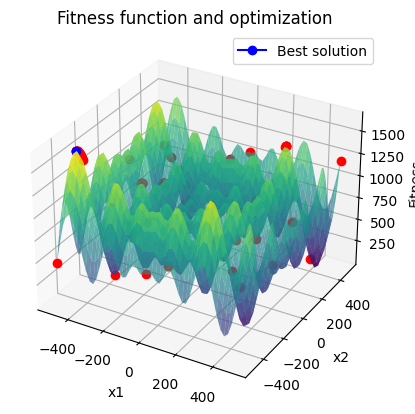

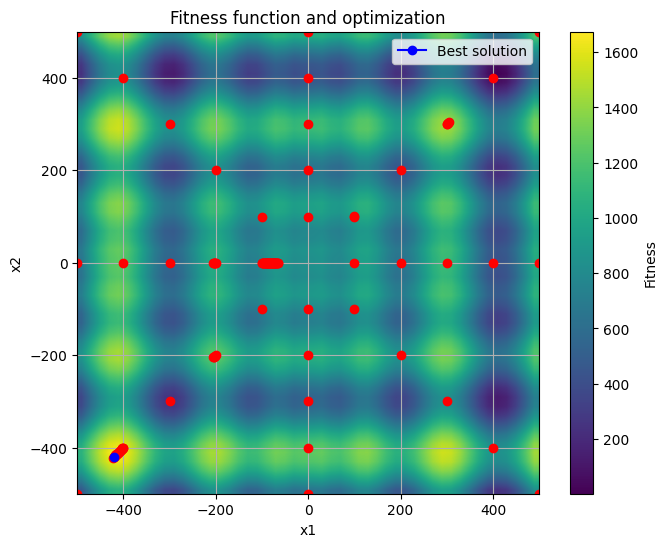

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X1, X2 = np.meshgrid(np.linspace(-500, 500, 50), np.linspace(-500, 500, 50))

# Initialize an empty array to store the cost values
Z = np.zeros_like(X1)

# Calculate the cost for each combination of X1 and X2
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        Z[i][j] = schwefel([X1[i][j], X2[i][j]])

# Plot the surface
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.7)

for region in range(num_regions):
    for neighborhood in range(num_neighborhoods):
        ax.plot([i[0][0] for i in history[region][neighborhood]], 
                [i[0][1] for i in history[region][neighborhood]], 
                [i[1] for i in history[region][neighborhood]], 
                marker='o', linestyle='-', color='red')

ax.plot(best_x[0], best_x[1], best_fit, marker='o', linestyle='-', color='blue', label='Best solution')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Fitness')
ax.set_title('Fitness function and optimization')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(-500, 500, -500, 500), origin='lower', cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Fitness')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fitness function and optimization')
plt.grid(True)

# Overlay the optimization path on the heatmap as red dots
for region in range(num_regions):
    for neighborhood in range(num_neighborhoods):
        plt.plot([i[0][0] for i in history[region][neighborhood]], [i[0][1] for i in history[region][neighborhood]], c='red', marker='o', linestyle='-')

plt.plot(best_x[0], best_x[1], c='blue', marker='o', linestyle='-', label='Best solution')
plt.legend()
plt.show()